# What is about ?

Preliminary draft

Baseline to decompose element into product of generators by ML methods. Permutation groups. 

    - Generate train set by random walks , i.e. pairs (g, k) 
    - Train model to preduct k from g
    - Use it as heuristics in any algorithm which finds global minima of distnace, e.g. Metpropolis
    
    



# Example to use one-hot  encoding to convert permutations from vector format to permutation-matrix format

https://en.wikipedia.org/wiki/Permutation_matrix

## Prepare 

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Examples 

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from tqdm.notebook import tqdm
import time
t0start = time.time() 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
import copy

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
i = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
#     if dirname == '/kaggle/input/growth-in-finite-groups/UT4_growth':
    for filename in filenames:
        i+=1
        if i<= 1:
            print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 

# Preliminaries 

In [3]:
import torch 
import math

if torch.cuda.is_available():
    device = torch.device("cuda")
    dtype = torch.float
else:
    device = torch.device("cpu")
    dtype = torch.float#int16  
    dtype = torch.int16  
    
print(dtype)    
print(device)


torch.float32
cuda


# Preliminaries Groups data 

## Load moves data 

In [4]:
import numpy as np
import pandas as pd 
# fn = '/kaggle/input/santa-2023/puzzle_info.csv'
fn = '/kaggle/input/growth-in-finite-groups/puzzle_info.csv'
di = pd.read_csv(fn)
di['n_generators'] = di['allowed_moves'].apply(lambda x: len(x.split(':'))-1)
di['vector_len'] = di['allowed_moves'].apply(lambda x: len(x.split(']')[0].split('[')[1].split(',')))
di['puzzle_type_brief'] = di['puzzle_type'].apply(lambda x: x.split('_')[0])

display(di)
di.to_csv('moves.csv')

,puzzle_type,allowed_moves,n_generators,vector_len,puzzle_type_brief
0,cube_2/2/2,"{'f0': [0, 1, 19, 17, 6, 4, 7, 5, 2, 9, 3, 11,...",6,24,cube
1,cube_3/3/3,"{'f0': [0, 1, 2, 3, 4, 5, 44, 41, 38, 15, 12, ...",9,54,cube
2,cube_4/4/4,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",12,96,cube
3,cube_5/5/5,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",15,150,cube
4,cube_6/6/6,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",18,216,cube
5,cube_7/7/7,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",21,294,cube
6,cube_8/8/8,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",24,384,cube
7,cube_9/9/9,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",27,486,cube
8,cube_10/10/10,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",30,600,cube
9,cube_19/19/19,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",57,2166,cube


In [5]:
1

1

## Choose example (e.g. 2x2x2 or 3x3x3 cube or etc )

In [6]:
group_gens_id ='cube_2/2/2'
group_gens_id ='cube_3/3/3'
group_gens_id ='cube_4/4/4'

m = di['puzzle_type'] == group_gens_id
allowed_moves = di['allowed_moves'][m].iat[0]
allowed_moves = str( allowed_moves ).replace("'", '"')
import json
dict_allowed_moves = json.loads(allowed_moves)
print(str(dict_allowed_moves)[:500] )
vec_len = len( dict_allowed_moves[list(dict_allowed_moves.keys())[0]])
array_allowed_moves = np.zeros(  (len(dict_allowed_moves),  vec_len), dtype = int )
for i in range(len(dict_allowed_moves)):
    array_allowed_moves[i,:] = dict_allowed_moves[list(dict_allowed_moves.keys())[i]]
array_allowed_moves    

list_generators = list(dict_allowed_moves.values())
print()
print(str(list_generators)[:500])

n_gens = len(list_generators)
print('number of generators:', n_gens)

{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 79, 75, 71, 67, 28, 24, 20, 16, 29, 25, 21, 17, 30, 26, 22, 18, 31, 27, 23, 19, 12, 33, 34, 35, 13, 37, 38, 39, 14, 41, 42, 43, 15, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 80, 68, 69, 70, 81, 72, 73, 74, 82, 76, 77, 78, 83, 44, 40, 36, 32, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95], 'f1': [0, 1, 2, 3, 4, 5, 6, 7, 78, 74, 70, 66, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 79, 75, 71, 67, 28, 24, 20, 16, 29, 25, 21, 17, 30, 26, 22, 18, 31, 27, 23, 19, 12, 33, 34, 35, 13, 37, 38, 39, 14, 41, 42, 43, 15, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 80, 68, 69, 70, 81, 72, 73, 74, 82, 76, 77, 78, 83, 44, 40, 36, 32, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95], [0, 1, 2, 3, 4, 5, 6, 7, 78, 74, 70, 66, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 

In [7]:
len(dict_allowed_moves['f0']), len(dict_allowed_moves['f1'])

(96, 96)

In [8]:
1

1

In [9]:
len(list_generators), len(list_generators[0])

(12, 96)

In [10]:
def inverse_permutation(perm):
    # Create an empty list to hold the inverse permutation
    inverse = [0] * len(perm)
    
    # Iterate over the original permutation
    for i, p in enumerate(perm):
        # Place the index at the correct position in the inverse permutation
        inverse[p] = i
    
    return inverse

list_generators_add_inverses = []
for perm in list_generators:
    perm_inv = inverse_permutation(perm)
    list_generators_add_inverses.append(perm)
    if perm_inv != perm:
        list_generators_add_inverses.append(perm_inv)
    else:
        print('perm == perm_inv - skipped')
        print(perm)        
        print(perm_inv)
        
list_generators =   list_generators_add_inverses     
print('List updated with inverses:')
print(str(list_generators)[:500])

list_generators_clean_duplicates = []
for p1 in list_generators:
    flag_already_in = False
    for p in list_generators_clean_duplicates:
        if p1 == p : 
            flag_already_in = True
            break
    if not flag_already_in :
        list_generators_clean_duplicates.append(p1)
        
list_generators = list_generators_clean_duplicates

n_gens = len(list_generators)       
print('number of generators:', n_gens)

List updated with inverses:
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 79, 75, 71, 67, 28, 24, 20, 16, 29, 25, 21, 17, 30, 26, 22, 18, 31, 27, 23, 19, 12, 33, 34, 35, 13, 37, 38, 39, 14, 41, 42, 43, 15, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 80, 68, 69, 70, 81, 72, 73, 74, 82, 76, 77, 78, 83, 44, 40, 36, 32, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 32, 36, 40, 44, 19, 23, 27, 31, 18, 22, 26, 30, 17, 21, 25, 29, 16, 20, 24, 28, 83, 
number of generators: 24


In [11]:
%%time
state_size = len(list_generators[0])
print('state_size:',state_size)
all_moves = torch.zeros( n_gens, state_size ,  device=device, dtype = torch.int32)
for k in range(n_gens):
    all_moves[k,:] = torch.tensor( list_generators[k],  device=device, dtype = torch.int32)
# all_moves

state_size: 96
CPU times: user 26.2 ms, sys: 98 ms, total: 124 ms
Wall time: 203 ms


In [12]:
all_moves.shape

torch.Size([24, 96])

# Train set generation

## Function to generate

In [13]:
%%time

def random_walks(generators , n_random_walk_length,  n_random_walks_to_generate,    rw_start = None, 
                 device=device, dtype = dtype , verbose = 0   ):
    '''
    Output:
    returns X,y: X - array of states, y - number of steps rw achieves it
    
    Input: 
    generators - generators (moves) to make random walks  (permutations), 
        can be list of vectors or array with vstacked vectors
    n_random_walk_length - number of visited nodes, i.e. number of steps + 1 
    n_random_walks_to_generate - how many random walks will run in parrallel
    rw_start - initial states for random walks - by default we will use 0,1,2,3 ...
        Can be vector or array
        If it is vector it will be broadcasted n_random_walks_to_generate times, 
        If it is array n_random_walks_to_generate - input n_random_walks_to_generate will be ignored
            and will be assigned: n_random_walks_to_generate = rw_start.shape[0]
    
    '''

    # Prepare generators in tensor format:
    if isinstance(generators, list):
        state_size = len(generators[0])
        all_moves = torch.zeros( n_gens, state_size ,  device=device, dtype = torch.int32) # Cannot use signed types 
        for k in range(n_gens):
            all_moves[k,:] = torch.tensor( generators[k],  device=device, dtype = torch.int32) 
    else:
        all_moves = generators
        state_size = generators.shape[1]
    n_generators = all_moves.shape[0] 
    
    if verbose >= 100:
        print('state_size', state_size )
        

    # Initialize current array of steps with  state_rw_start - expanding (broadcasting) it into array: 
    if rw_start is None:        
        # Starting state for random walks (for train data it is our destination state - "solved puzzle state")  
        state_rw_start = torch.arange( state_size, device=device, dtype = dtype)
        array_of_states = state_rw_start.view(1, state_size  ).expand(n_random_walks_to_generate, state_size )
    else:
        if len(rw_start.shape) == 1:
            array_of_states = rw_start.view(1, state_size  ).expand(n_random_walks_to_generate, state_size )
        else :
            array_of_states = rw_start
    if verbose >= 100:
        print('state_rw_start.shape:', state_rw_start.shape)
        print('state_rw_start:',state_rw_start)
        print(array_of_states.shape)
        print( array_of_states[:3,:] )

    # Output: X,y - states, y - how many steps we achieve them 
    # Allocate memory: 
    X = torch.zeros( (n_random_walks_to_generate)*n_random_walk_length , state_size,    device=device, dtype = dtype )
    y = torch.zeros( (n_random_walks_to_generate)*n_random_walk_length ,    device=device, dtype = dtype )
    if verbose >= 100:
        print('X.shape',X.shape)

    # First portion of data  - just our state_rw_start state  multiplexed many times
    X[:n_random_walks_to_generate,:] = array_of_states
    y[:n_random_walks_to_generate] = 0

    # Technical to make array[ IX_array] we need  actually to write array[ range(N), IX_array  ]
    row_indices = torch.arange( array_of_states.shape[0] , device=device, dtype = dtype )
    row_indices = np.arange( array_of_states.shape[0] )[:, np.newaxis]

    # Main loop 
    for i_step in range(1,n_random_walk_length):
        y[ (i_step)*n_random_walks_to_generate : (i_step+1)*n_random_walks_to_generate  ] = i_step
        IX_moves = np.random.randint(0, n_generators, size=n_random_walks_to_generate, dtype = int) # random moves indixes
        new_array_of_states = array_of_states[ row_indices , all_moves[IX_moves,:]] # all_moves[IX_moves,:] ] 
        array_of_states = new_array_of_states
        X[ (i_step)*n_random_walks_to_generate : (i_step+1)*n_random_walks_to_generate , : ] = new_array_of_states

    if verbose >= 100:
        print(array_of_states.shape, 'array_of_states.shape')
        print(n_random_walk_length, 'n_random_walk_length', state_size,'state_size', '' )    
        print('Finished')
        print(str(X)[:500] )
        print(str(y)[:500] )
        
    return X,y

# X_tmp, y_tmp = random_walks(list_generators , n_random_walk_length = 3,  n_random_walks_to_generate =  2) #,    rw_start = None, 
#                  #device=device, dtype = dtype , verbose = 0   )

# print('X:')
# print('X.shape', X_tmp.shape)
# print(X_tmp)

# print('y')
# print('y.shape', y_tmp.shape)
# print(y_tmp)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.34 µs


In [14]:
n_random_walk_length = 10
n_random_walks_to_generate = 10_000
generators = list_generators
verbose = 0
# Prepare generators in tensor format:
if isinstance(generators, list):
    state_size = len(generators[0])
    all_moves = torch.zeros( n_gens, state_size ,  device=device, dtype = torch.int32) # Cannot use signed types 
    for k in range(n_gens):
        all_moves[k,:] = torch.tensor( generators[k],  device=device, dtype = torch.int32) 
else:
    all_moves = generators
    state_size = generators.shape[1]
n_generators = all_moves.shape[0] 

if verbose >= 100:
    print('state_size', state_size )
    
        
# Starting state for random walks (for train data it is our destination state - "solved puzzle state")  
state_rw_start = torch.arange( state_size, device=device, dtype = dtype)
array_of_states = state_rw_start.view(1, state_size  ).expand(n_random_walks_to_generate, state_size )

# Output: X,y - states, y - how many steps we achieve them 
# Allocate memory: 
X = torch.zeros( (n_random_walks_to_generate)*n_random_walk_length , state_size,    device=device, dtype = dtype )
y = torch.zeros( (n_random_walks_to_generate)*n_random_walk_length ,    device=device, dtype = dtype )
if verbose >= 100:
    print('X.shape',X.shape)

# First portion of data  - just our state_rw_start state  multiplexed many times
X[:n_random_walks_to_generate,:] = array_of_states
y[:n_random_walks_to_generate] = 0

# # Technical to make array[ IX_array] we need  actually to write array[ range(N), IX_array  ]
# row_indices = torch.arange( array_of_states.shape[0] , device=device, dtype = dtype )
# row_indices = np.arange( array_of_states.shape[0] )[:, np.newaxis]

# # Main loop 
# for i_step in range(1,n_random_walk_length):
#     y[ (i_step)*n_random_walks_to_generate : (i_step+1)*n_random_walks_to_generate  ] = i_step
#     IX_moves = np.random.randint(0, n_generators, size=n_random_walks_to_generate, dtype = int) # random moves indixes
#     new_array_of_states = array_of_states[ row_indices , all_moves[IX_moves,:]] # all_moves[IX_moves,:] ] 
#     array_of_states = new_array_of_states
#     X[ (i_step)*n_random_walks_to_generate : (i_step+1)*n_random_walks_to_generate , : ] = new_array_of_states

# if verbose >= 100:
#     print(array_of_states.shape, 'array_of_states.shape')
#     print(n_random_walk_length, 'n_random_walk_length', state_size,'state_size', '' )    
#     print('Finished')
#     print(str(X)[:500] )
#     print(str(y)[:500] )
    

In [15]:
X.shape, y.shape

(torch.Size([100000, 96]), torch.Size([100000]))

In [16]:
X[0]

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
        56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
        70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83.,
        84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95.],
       device='cuda:0')

In [17]:
# Define transformations
def shift_left(row):
    # Roll/rotate the row 1 position to the left
    return torch.roll(row, shifts=-1, dims=0)

def shift_right(row):
    # Roll/rotate the row 1 position to the right
    return torch.roll(row, shifts=1, dims=0)

def swap_first_two(row):
    # Swap the first two elements
    row_copy = row.clone()
    temp = row_copy[0].clone()
    row_copy[0] = row_copy[1]
    row_copy[1]= temp
    return row_copy

In [18]:
N = 100000
block_size = 10000
num_iterations = N // block_size

In [19]:
from tqdm import tqdm

In [20]:
# List the possible transformations
transforms = [shift_left, shift_right, swap_first_two]

# 2) For each iteration i = 1..(num_iterations-1):
#    - Fill rows i*block_size : (i+1)*block_size
#      using the corresponding rows from the previous block
#    - Each row randomly undergoes exactly one of the transformations
#    - y will show the iteration number
for i in tqdm(range(1, num_iterations)):
    start_idx = i * block_size
    end_idx = (i + 1) * block_size
    
    for j in range(block_size):
        prev_row_index = start_idx - block_size + j
        # Randomly pick one of the transformations
        transform = np.random.choice(transforms)
        
        # Apply it to the corresponding row from the previous block
        X[start_idx + j] = transform(X[prev_row_index])
        
        # Set y to the current iteration index
        y[start_idx + j] = i

100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


In [21]:
%%time

def prepare_data(generators , n_random_walk_length,  n_random_walks_to_generate,    rw_start = None, 
                 device=device, dtype = dtype , verbose = 0   ):
    '''
    Output:
    returns X,y: X - array of states, y - number of steps rw achieves it
    
    Input: 
    generators - generators (moves) to make random walks  (permutations), 
        can be list of vectors or array with vstacked vectors
    n_random_walk_length - number of visited nodes, i.e. number of steps + 1 
    n_random_walks_to_generate - how many random walks will run in parrallel
    rw_start - initial states for random walks - by default we will use 0,1,2,3 ...
        Can be vector or array
        If it is vector it will be broadcasted n_random_walks_to_generate times, 
        If it is array n_random_walks_to_generate - input n_random_walks_to_generate will be ignored
            and will be assigned: n_random_walks_to_generate = rw_start.shape[0]
    
    '''

    # Prepare generators in tensor format:
    if isinstance(generators, list):
        state_size = len(generators[0])
        all_moves = torch.zeros( n_gens, state_size ,  device=device, dtype = torch.int32) # Cannot use signed types 
        for k in range(n_gens):
            all_moves[k,:] = torch.tensor( generators[k],  device=device, dtype = torch.int32) 
    else:
        all_moves = generators
        state_size = generators.shape[1]
    n_generators = all_moves.shape[0] 
    
    if verbose >= 100:
        print('state_size', state_size )
        

    state_rw_start = torch.arange( state_size, device=device, dtype = dtype)
    array_of_states = state_rw_start.view(1, state_size  ).expand(n_random_walks_to_generate, state_size )

    # Output: X,y - states, y - how many steps we achieve them 
    # Allocate memory: 
    X = torch.zeros( (n_random_walks_to_generate)*n_random_walk_length , state_size,    device=device, dtype = dtype )
    y = torch.zeros( (n_random_walks_to_generate)*n_random_walk_length ,    device=device, dtype = dtype )
    if verbose >= 100:
        print('X.shape',X.shape)

    # First portion of data  - just our state_rw_start state  multiplexed many times
    X[:n_random_walks_to_generate,:] = array_of_states
    y[:n_random_walks_to_generate] = 0

    N = n_random_walk_length * n_random_walks_to_generate
    block_size = 10000
    num_iterations = N // block_size
    # List the possible transformations
    transforms = [shift_left, shift_right, swap_first_two]
    
    # 2) For each iteration i = 1..(num_iterations-1):
    #    - Fill rows i*block_size : (i+1)*block_size
    #      using the corresponding rows from the previous block
    #    - Each row randomly undergoes exactly one of the transformations
    #    - y will show the iteration number
    for i in range(1, num_iterations):
        start_idx = i * block_size
        end_idx = (i + 1) * block_size
        
        for j in range(block_size):
            prev_row_index = start_idx - block_size + j
            # Randomly pick one of the transformations
            transform = np.random.choice(transforms)
            
            # Apply it to the corresponding row from the previous block
            X[start_idx + j] = transform(X[prev_row_index])
            
            # Set y to the current iteration index
            y[start_idx + j] = i
        
    return X,y

# X_tmp, y_tmp = random_walks(list_generators , n_random_walk_length = 3,  n_random_walks_to_generate =  2) #,    rw_start = None, 
#                  #device=device, dtype = dtype , verbose = 0   )

# print('X:')
# print('X.shape', X_tmp.shape)
# print(X_tmp)

# print('y')
# print('y.shape', y_tmp.shape)
# print(y_tmp)

CPU times: user 0 ns, sys: 5 µs, total: 5 µs
Wall time: 8.11 µs


## Generation

In [22]:
X_train, y_train = prepare_data(list_generators ,n_random_walk_length = 10 ,  n_random_walks_to_generate = 10_000 ) #,    rw_start = None, 
                 #device=device, dtype = dtype , verbose = 0   )

X_test, y_test = prepare_data(list_generators ,n_random_walk_length = 10 ,  n_random_walks_to_generate = 10_000 ) #,    rw_start = None, 
                 #device=device, dtype = dtype , verbose = 0   )
    

In [23]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([100000, 96]),
 torch.Size([100000]),
 torch.Size([100000, 96]),
 torch.Size([100000]))

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

In [25]:
class MatrixDatasetRegr(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.int64)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = F.one_hot(self.X[idx], num_classes=self.X.shape[1]).float()
        return x.unsqueeze(0), self.y[idx]


train_dataset = MatrixDatasetRegr(X_train, y_train)
test_dataset = MatrixDatasetRegr(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
# model = CNNRegr().to(device)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

def calculate_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    r2 = r2_score(all_targets, all_preds)
    
    return rmse, r2

In [26]:

class CNN_96x96(nn.Module):
    def __init__(self):
        super(CNN_96x96, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        # Calculate the size of the flattened feature map
        self.feature_size = 128 * 12 * 12  # After 3 pooling operations: 96 -> 48 -> 24 -> 12
        
        self.fc1 = nn.Linear(self.feature_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Output: 48x48
        x = self.dropout1(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Output: 24x24
        x = self.dropout1(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Output: 12x12
        x = self.dropout1(x)
        
        x = x.view(-1, self.feature_size)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        
        return x.squeeze(1)
    
model = CNN_96x96().to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1000000
print(f'Total trainable parameters: {pytorch_total_params}')

# Training loop
num_epochs = 200
train_rmse_list, train_r2_list = [], []
test_rmse_list, test_r2_list = [], []
loss_list = []


best_test_rmse = float('inf')
patience = 20
no_improve = 0

best_model_weights = copy.deepcopy(model.state_dict())
for epoch in range(num_epochs):
    X_train, y_train = prepare_data(list_generators ,n_random_walk_length = 10 ,  n_random_walks_to_generate = 10_000 ) #,    rw_start = None, 
                 #device=device, dtype = dtype , verbose = 0   )

    train_dataset = MatrixDatasetRegr(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    # Calculate metrics for train and test data
    train_rmse, train_r2 = calculate_metrics(model, train_loader)
    test_rmse, test_r2 = calculate_metrics(model, test_loader)
    train_rmse_list.append(train_rmse)
    train_r2_list.append(train_r2)
    test_rmse_list.append(test_rmse)
    test_r2_list.append(test_r2)
    
    scheduler.step(test_rmse)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    print(f'Train - RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}')
    print(f'Test  - RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}')
    # Early stopping
    if test_rmse < best_test_rmse:
        best_test_rmse = test_rmse
        no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
        best_model_weights = copy.deepcopy(model.state_dict())
    else:
        no_improve += 1
        if no_improve == patience:
            print("Early stopping triggered")
            break
print('Finished Training')
print(f'Best metrics: {min(test_rmse_list)=:.4f} {max(test_r2_list)=:.4f}')
model.load_state_dict(best_model_weights)

Total trainable parameters: 9.629889
Epoch [1/200], Loss: 4.2702
Train - RMSE: 2.9785, R²: -0.0753
Test  - RMSE: 2.9794, R²: -0.0760
Epoch [2/200], Loss: 5.2752
Train - RMSE: 2.5728, R²: 0.1977
Test  - RMSE: 2.5780, R²: 0.1944
Epoch [3/200], Loss: 6.5468
Train - RMSE: 2.4888, R²: 0.2492
Test  - RMSE: 2.4781, R²: 0.2556
Epoch [4/200], Loss: 5.7075
Train - RMSE: 2.5137, R²: 0.2341
Test  - RMSE: 2.5141, R²: 0.2338
Epoch [5/200], Loss: 4.7850
Train - RMSE: 2.3622, R²: 0.3236
Test  - RMSE: 2.3524, R²: 0.3292
Epoch [6/200], Loss: 2.6195
Train - RMSE: 2.4525, R²: 0.2710
Test  - RMSE: 2.4525, R²: 0.2709
Epoch [7/200], Loss: 3.7750
Train - RMSE: 2.3667, R²: 0.3210
Test  - RMSE: 2.3491, R²: 0.3311
Epoch [8/200], Loss: 5.3537
Train - RMSE: 2.2680, R²: 0.3765
Test  - RMSE: 2.2710, R²: 0.3749
Epoch [9/200], Loss: 4.1139
Train - RMSE: 2.2992, R²: 0.3593
Test  - RMSE: 2.2865, R²: 0.3663
Epoch [10/200], Loss: 6.7912
Train - RMSE: 2.2637, R²: 0.3789
Test  - RMSE: 2.2651, R²: 0.3781
Epoch [11/200], Loss

<All keys matched successfully>

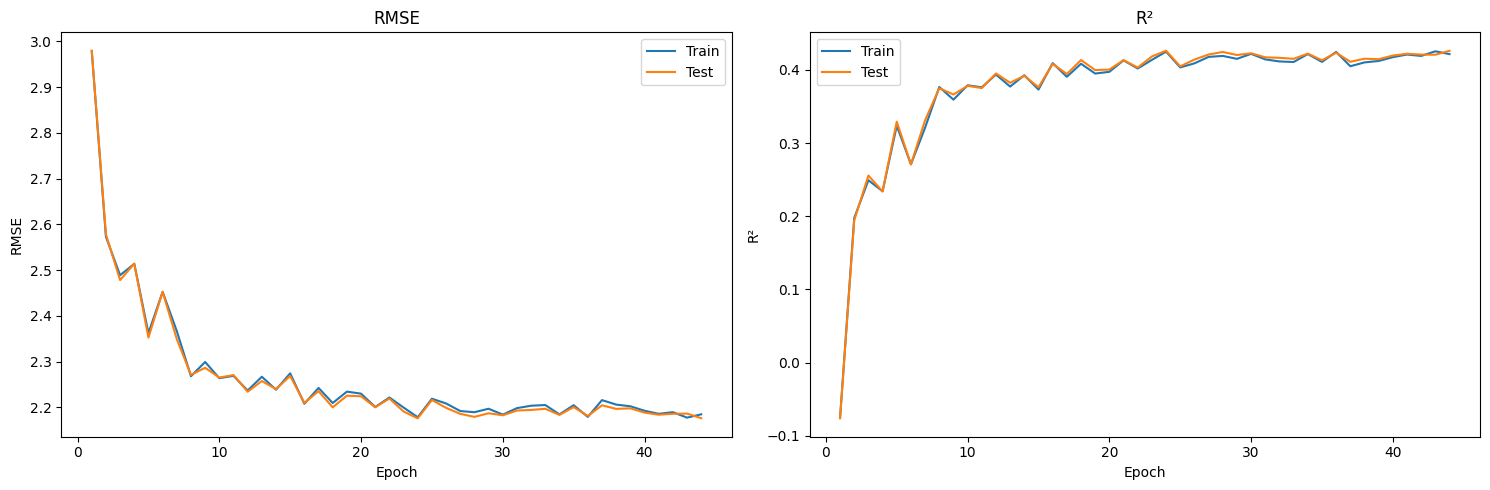

In [27]:
# Plotting the metrics
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_rmse_list)+1), train_rmse_list, label='Train')
plt.plot(range(1, len(test_rmse_list)+1), test_rmse_list, label='Test')
plt.title('RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_r2_list)+1), train_r2_list, label='Train')
plt.plot(range(1, len(test_r2_list)+1), test_r2_list, label='Test')
plt.title('R²')
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
def make_predictions(model, data_loader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            all_preds.extend(outputs.cpu().numpy())
    
    all_preds = np.array(all_preds)
    
    return all_preds


In [29]:
import warnings
warnings.filterwarnings('ignore')

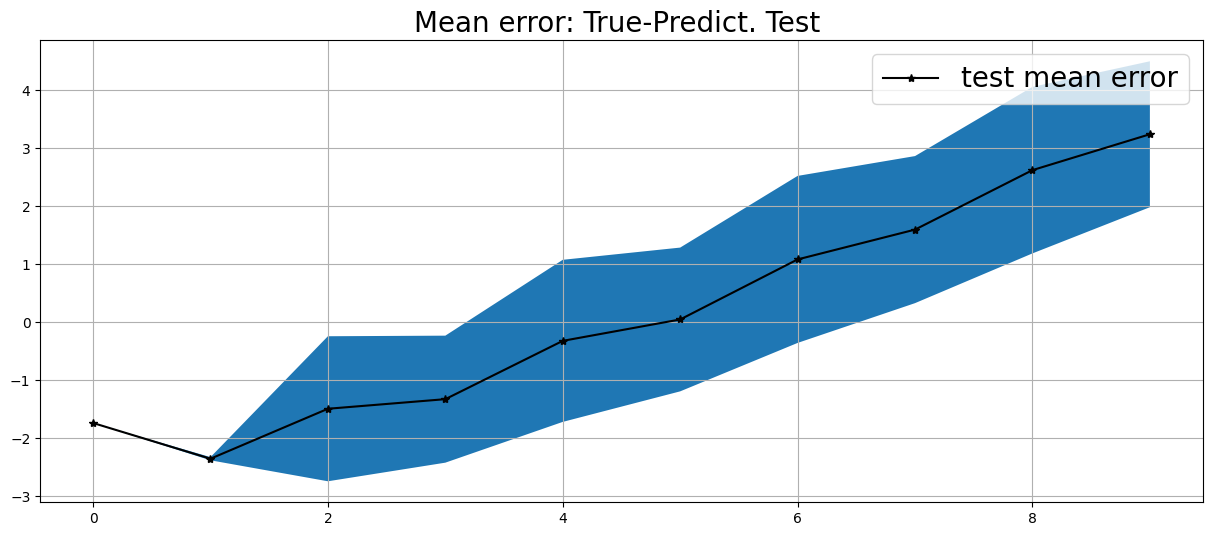

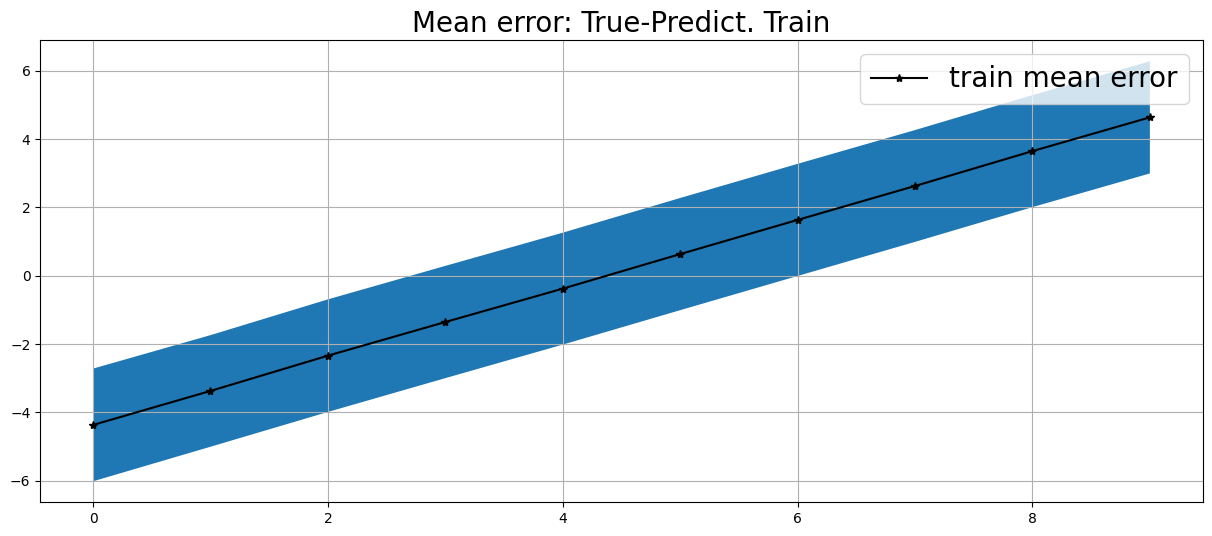

CPU times: user 25.4 s, sys: 343 ms, total: 25.8 s
Wall time: 25.2 s


In [30]:
%%time 
list_uv = np.unique(y_test.detach().cpu().numpy())

# y_pred = model.predict(X_test)
y_pred = make_predictions(model, test_loader)
# rmse_test = mean_squared_error(y_test, y_pred,  squared=False)
rmse = test_rmse
y_true = y_test.detach().cpu().numpy()
df1 = pd.DataFrame()
for k in list_uv:
    mask = y_true == k
    er = np.mean(y_true[mask]- y_pred[mask])
    st = np.std(y_true[mask]- y_pred[mask])
    df1.loc[k,'mean error'] = np.mean(er)
    df1.loc[k,'std'] = st
    
x = df1.index
y = df1['mean error'].values
error =  df1['std'].values
plt.figure(figsize=(15,6))
plt.plot(x,y ,'k*-',  label = 'test mean error')
plt.fill_between(x, y-error, y+error)

plt.title('Mean error: True-Predict. Test ', fontsize = 20)
plt.legend(fontsize = 20 )
plt.grid()
plt.show()

#################################################################
# Same for train 
#################################################################

# y_pred = model.predict(X_train)

y_pred = make_predictions(model, train_loader)
# rmse_test = mean_squared_error(y_test, y_pred,  squared=False)
rmse_test = train_rmse
y_true = y_train.detach().cpu().numpy()
df1 = pd.DataFrame()
for k in list_uv:
    mask = y_true == k
    er = np.mean(y_true[mask]- y_pred[mask])
    st = np.std(y_true[mask]- y_pred[mask])
    df1.loc[k,'mean error'] = np.mean(er)
    df1.loc[k,'std'] = st
    
x = df1.index
y = df1['mean error'].values
error =  df1['std'].values
plt.figure(figsize=(15,6))
plt.plot(x,y ,'k*-',  label = 'train mean error')
plt.fill_between(x, y-error, y+error)

plt.title('Mean error: True-Predict. Train', fontsize = 20)
plt.legend(fontsize = 20 )
plt.grid()
plt.show()

(100000, 2) 100000 100000


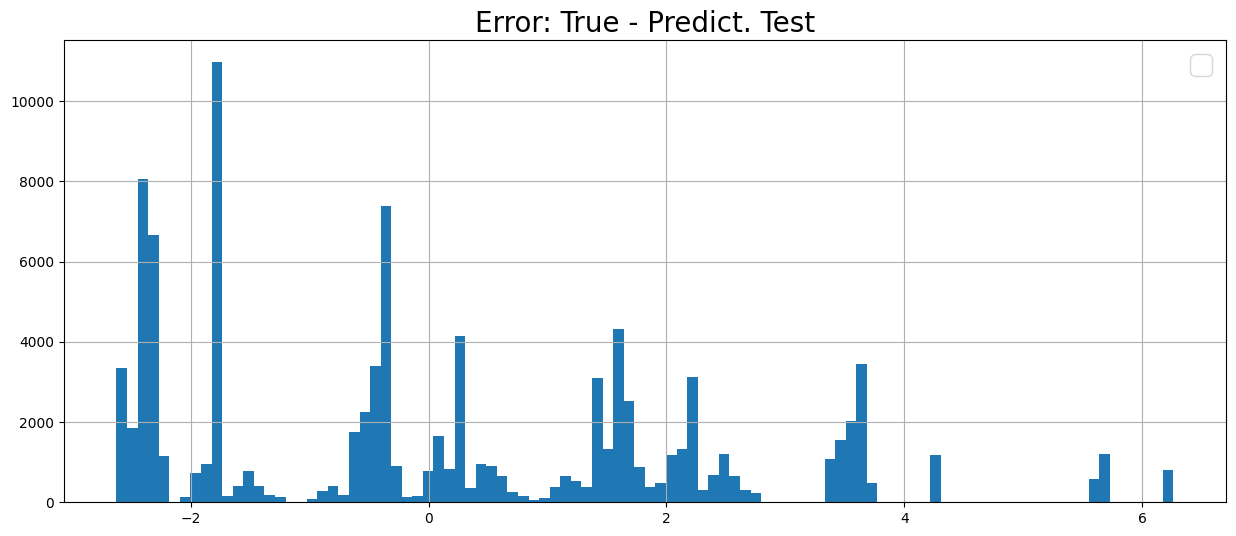

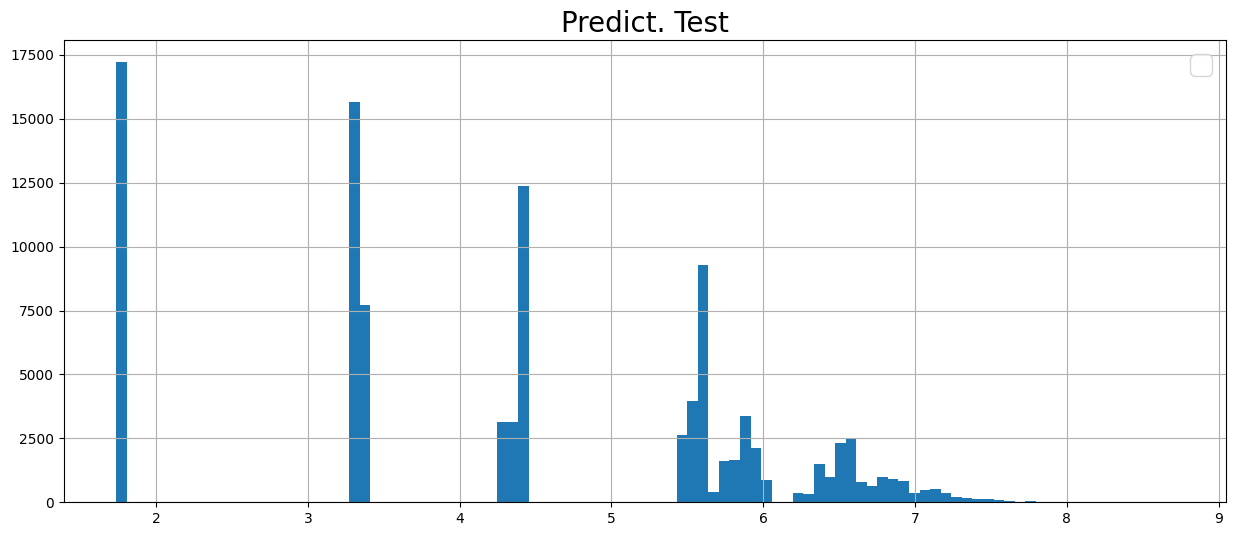

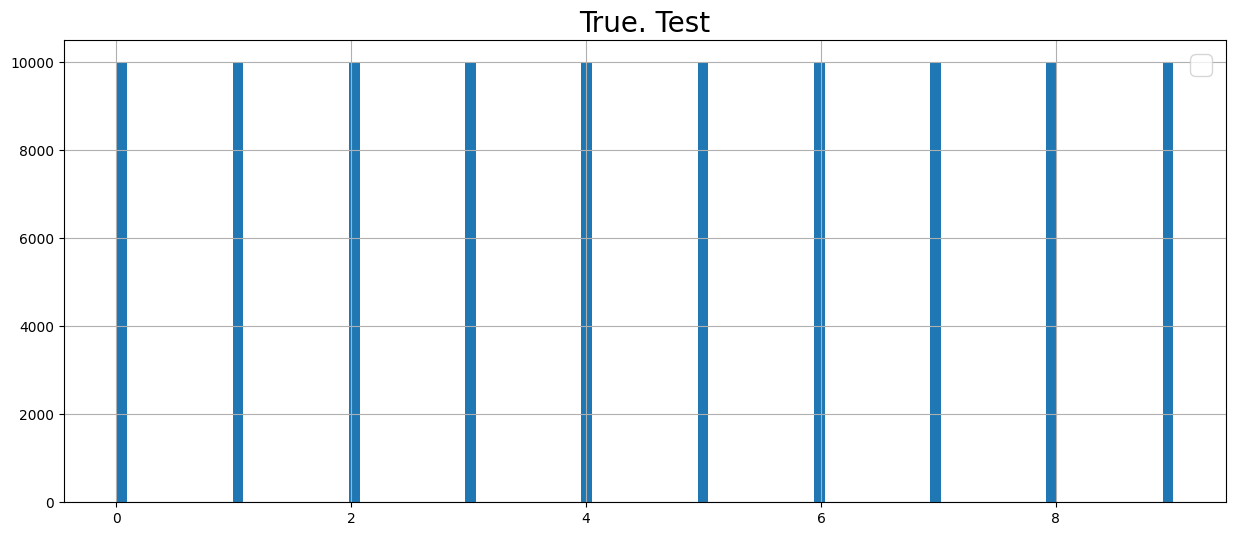

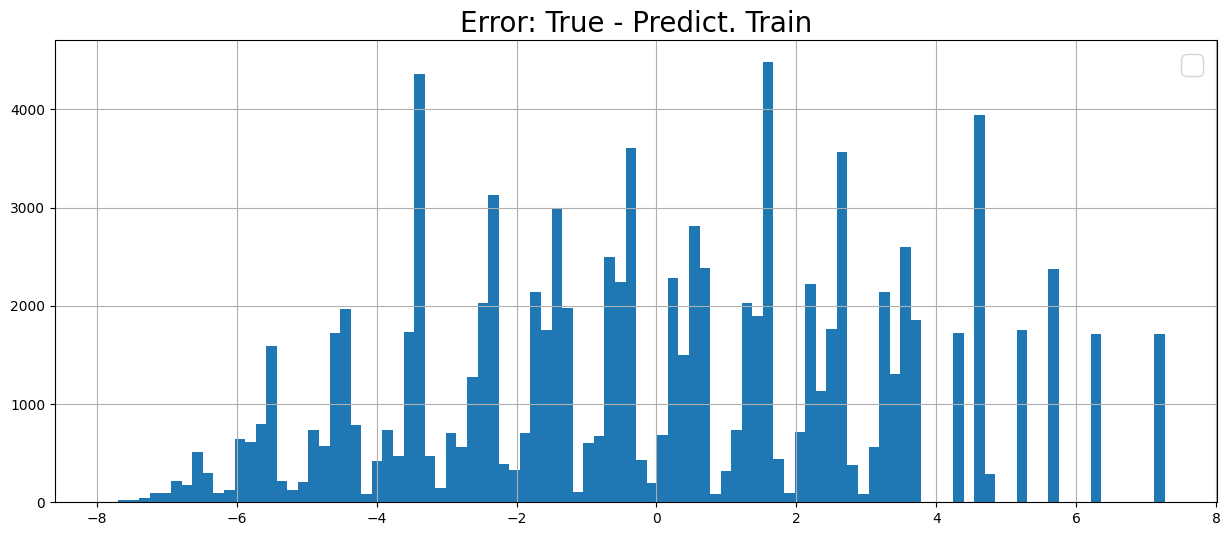

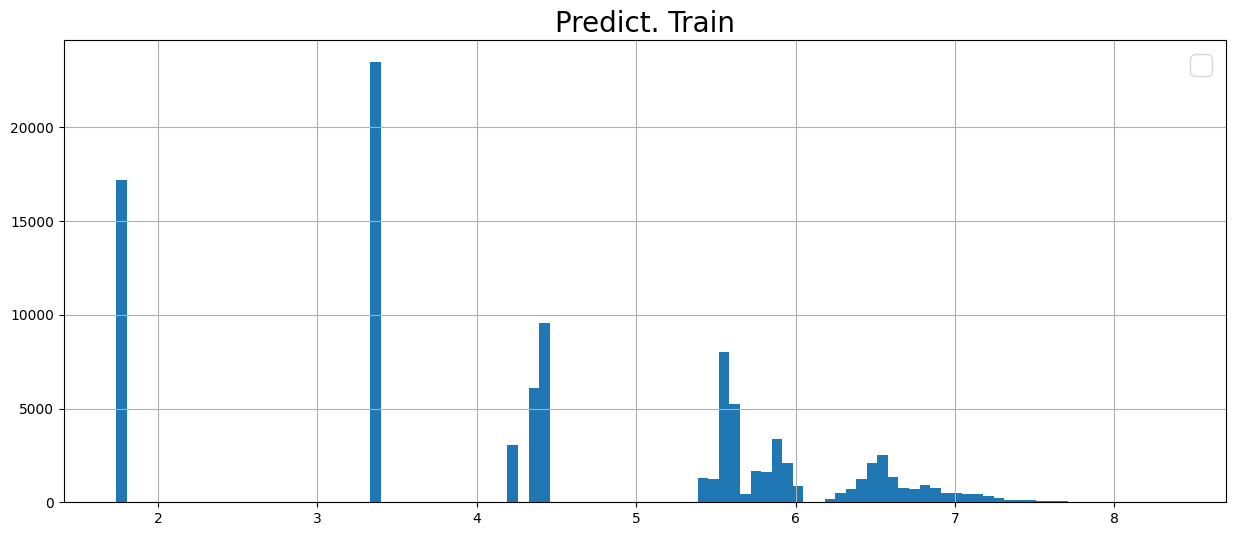

,Test Error,Test Predict,Train Error,Train Predict
count,100000.000,100000.000,100000.000,100000.000
mean,0.135,4.365,0.138,4.362
std,2.172,1.642,3.312,1.640
min,-2.624,1.739,-7.845,1.739
25%,-1.739,3.335,-2.393,3.335
50%,-0.335,4.407,0.261,4.407
75%,1.664,5.624,2.607,5.624
max,6.261,8.702,7.261,8.370


In [31]:
#%%time
df1 = pd.DataFrame()
#y_pred = model.predict(X_test)
y_pred = make_predictions(model, test_loader)
y_true = y_test.detach().cpu().numpy()
er = y_true - y_pred
df1['Test Error'] = er
df1['Test Predict'] = y_pred
print(df1.shape, len(er), len(y_pred))
plt.figure(figsize=(15,6))
plt.hist(er, bins = 100)
plt.title('Error: True - Predict. Test', fontsize = 20)
plt.legend(fontsize = 20 )
plt.grid()
plt.show()

plt.figure(figsize=(15,6))
plt.hist(y_pred, bins = 100)
plt.title('Predict. Test', fontsize = 20)
plt.legend(fontsize = 20 )
plt.grid()
plt.show()

plt.figure(figsize=(15,6))
plt.hist(y_true, bins = 100)
plt.title('True. Test', fontsize = 20)
plt.legend(fontsize = 20 )
plt.grid()
plt.show()



# y_pred = model.predict(X_train)
y_pred = make_predictions(model, train_loader)
y_true = y_train.detach().cpu().numpy()
er = y_true - y_pred
df1['Train Error'] = er
df1['Train Predict'] = y_pred
plt.figure(figsize=(15,6))
plt.hist(er, bins = 100)
plt.title('Error: True - Predict. Train', fontsize = 20)
plt.legend(fontsize = 20 )
plt.grid()
plt.show()

plt.figure(figsize=(15,6))
plt.hist(y_pred, bins = 100)
plt.title('Predict. Train', fontsize = 20)
plt.legend(fontsize = 20 )
plt.grid()
plt.show()


er_stat = df1.describe().round(3)
display(er_stat)
er_stat.to_csv('error_stat.csv')

In [32]:
n_scrambles_starting_state = 1000
print('n_scrambles_starting_state:',n_scrambles_starting_state)


# destination state - "solved puzzle state"   
state_destination = torch.arange( state_size, device=device, dtype = dtype)


# Scramble - generate state which will be start of beam search  
state_start = state_destination
for k in range(n_scrambles_starting_state):
    IX_move = np.random.randint(0, n_gens, dtype = int) # random moves indixes
    state_start = state_start[ list_generators[IX_move]] # all_moves[IX_moves,:] ] 
    
state_start

n_scrambles_starting_state: 1000


tensor([92., 24., 18., 79., 68., 74., 26., 46., 17., 42., 58., 93., 67., 50.,
        78., 31., 12.,  1., 84., 83., 61., 25., 90., 65., 39., 73., 57., 20.,
        60., 27.,  8., 64., 44., 62., 91., 80.,  4., 38., 54., 30., 71., 10.,
        70., 36., 51., 59., 87., 48., 28., 14., 75., 76., 82., 41., 21., 56.,
        23.,  9., 86., 34., 35.,  2., 88., 15., 63., 55., 13., 16., 43.,  5.,
         6., 94.,  7., 89., 22., 52., 32., 11., 81., 47., 95., 40., 66.,  0.,
        29., 53., 69., 72., 33., 37., 85., 45., 19., 77., 49.,  3.],
       device='cuda:0')

In [33]:
%%time 

hash_vec = torch.randint(-(2**60), 2**60, (state_size,), dtype = torch.int64, device = device )
# hash_vec = torch.randint(0, 10**9, (state_size,), dtype = torch.int64, device = device )

def get_unique_states(states: torch.Tensor) -> torch.Tensor:
    '''
    Return matrix with unique rows for input matrix "states" 
    I.e. duplicate rows are dropped.
    For fast implementation: we use hashing via scalar/dot product.
    Note: output order of rows is different from the original. 
    '''
    # Note: that implementation is 30 times faster than torch.unique(states, dim = 0) - because we use hashes  (see K.Khoruzhii: https://t.me/sberlogasci/10989/15920)
    # Note: torch.unique does not support returning of indices of unique element so we cannot use it 
    # That is in contrast to numpy.unique which supports - set: return_index = True 
    
    
    # Hashing rows of states matrix: 
    hashed = torch.sum(hash_vec * states, dim=1) # Compute hashes. 
        # It is same as matrix product torch.matmul(hash_vec , states ) 
        # but pay attention: such code work with GPU for integers 
        # While torch.matmul - does not work for GPU for integer data types, 
        # since old GPU hardware (before 2020: P100, T4) does not support integer matrix multiplication 
    
    # Sort
    hashed_sorted, idx = torch.sort(hashed)
    # Mask selects elements which are different from the consequite - that is unique elements (since vector is sorted on the previous step)
    mask = torch.concat((torch.tensor([True], device = device), hashed_sorted[1:] - hashed_sorted[:-1] > 0))
    return states[idx][mask]

# Test run:
s = get_unique_states(state_start.view(1, state_size  ).expand(10, state_size ).clone())
print(s)
s.shape,s.dtype

tensor([[92., 24., 18., 79., 68., 74., 26., 46., 17., 42., 58., 93., 67., 50.,
         78., 31., 12.,  1., 84., 83., 61., 25., 90., 65., 39., 73., 57., 20.,
         60., 27.,  8., 64., 44., 62., 91., 80.,  4., 38., 54., 30., 71., 10.,
         70., 36., 51., 59., 87., 48., 28., 14., 75., 76., 82., 41., 21., 56.,
         23.,  9., 86., 34., 35.,  2., 88., 15., 63., 55., 13., 16., 43.,  5.,
          6., 94.,  7., 89., 22., 52., 32., 11., 81., 47., 95., 40., 66.,  0.,
         29., 53., 69., 72., 33., 37., 85., 45., 19., 77., 49.,  3.]],
       device='cuda:0')
CPU times: user 24 ms, sys: 12.8 ms, total: 36.7 ms
Wall time: 64.2 ms


(torch.Size([1, 96]), torch.float32)

In [34]:
class MatrixDatasetRegrSmall(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.int64)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = F.one_hot(self.X[idx], num_classes=self.X.shape[1]).float()
        return x.unsqueeze(0)
    
def make_predictions_on_array(model, array):
    model.eval()
    all_preds = []
    dataset = MatrixDatasetRegrSmall(array)
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    with torch.no_grad():
        for batch_X in loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            all_preds.extend(outputs.cpu().numpy())
    
    all_preds = np.array(all_preds)
    
    return all_preds



In [35]:
%%time
beam_width = 10_000

# Iabsolutenitialize array of states 
array_of_states = state_start.view(1, state_size  ).clone().to(dtype).to(device)

i_step_max = 100
for i_step in range(1,i_step_max+1):
    
    # Technical preparation: to apply permutations to array we need the trick:
    # naively it is: array[ :, IX_array], but actually we need  to write array[ range(N)[:, np.newaxis], IX_array  ]
    row_indices = np.arange( array_of_states.shape[0] )[:, np.newaxis]

    # Apply all moves to all current states, all new states saved in array_of_states_new
    array_of_states_new = torch.empty( (0,array_of_states.shape[1]) , device=device, dtype = dtype)
    for move in list_generators:
        array_of_states_tmp = array_of_states[row_indices,move]
        array_of_states_new = torch.concatenate([array_of_states_new, array_of_states_tmp],axis = 0)

    # Take only unique states 
    # surprise: THAT IS CRITICAL for beam search performance !!!!
    # if that is not done - beam search  will not find the desired state - quite often
    # The reason - essentianlly beam can degrade, i.e. can be populated by copy of only one state 
    # It is surprising that such degradation  happens quite often even for beam_width = 10_000 - but it is indeed so  
    array_of_states_new = get_unique_states(array_of_states_new)

    # Check destination state found 
    vec_tmp = torch.all(array_of_states_new == state_destination, axis =1) # Compare state_destination and each row array_of_states 
    flag_found_destination = torch.any(vec_tmp) # Check for coincidence
    if flag_found_destination:
        print('Found destination state. ', 'i_step:', i_step, ' n_ways:', (vec_tmp).sum()) 
        break
    
    # ML-model inference - estimate distance of new states to the destination state    
    t0 = time.time()
    if array_of_states_new.shape[0] > beam_width: # If we have not so many states - we take them all - no need for ML-model
        
        # ML-model inference - estimate distance of new states to the destination state
#         y_pred = model.predict(array_of_states_new.cpu().numpy() )
        y_pred = make_predictions_on_array(model, array_of_states_new.cpu().numpy() )
    
        # Take only "beam_width" of the best states (i.e. most nearest to destination according to the model estimate)
        idx = np.argsort(y_pred)[:beam_width]
        array_of_states = array_of_states_new[idx,:]
        
    else:
        array_of_states = array_of_states_new
    predict_time = time.time() - t0
    print(i_step,'i_step', '%.3f'%predict_time, 'predict_time', array_of_states_new.shape, 'array_of_states_new.shape' )

print();
print('Search finished.', 'beam_width:', beam_width)
if flag_found_destination:    
    print(i_step, ' steps to destination state. Path found.')
else:
    print('Path not found.')

1 i_step 0.000 predict_time torch.Size([24, 96]) array_of_states_new.shape
2 i_step 0.000 predict_time torch.Size([469, 96]) array_of_states_new.shape
3 i_step 0.000 predict_time torch.Size([9021, 96]) array_of_states_new.shape
4 i_step 21.538 predict_time torch.Size([172663, 96]) array_of_states_new.shape
5 i_step 27.663 predict_time torch.Size([222638, 96]) array_of_states_new.shape
6 i_step 28.174 predict_time torch.Size([227920, 96]) array_of_states_new.shape
7 i_step 28.355 predict_time torch.Size([228319, 96]) array_of_states_new.shape
8 i_step 28.190 predict_time torch.Size([228614, 96]) array_of_states_new.shape
9 i_step 28.276 predict_time torch.Size([227864, 96]) array_of_states_new.shape
10 i_step 28.090 predict_time torch.Size([227116, 96]) array_of_states_new.shape
11 i_step 28.059 predict_time torch.Size([226862, 96]) array_of_states_new.shape
12 i_step 28.418 predict_time torch.Size([226772, 96]) array_of_states_new.shape
13 i_step 28.185 predict_time torch.Size([226706,

In [36]:
%%time 

hash_vec = torch.randint(-(2**60), 2**60, (state_size,), dtype = torch.int64, device = device )
# hash_vec = torch.randint(0, 10**9, (state_size,), dtype = torch.int64, device = device )

def get_unique_states(states: torch.Tensor) -> torch.Tensor:
    '''
    Return matrix with unique rows for input matrix "states" 
    I.e. duplicate rows are dropped.
    For fast implementation: we use hashing via scalar/dot product.
    Note: output order of rows is different from the original. 
    '''
    # Note: that implementation is 30 times faster than torch.unique(states, dim = 0) - because we use hashes  (see K.Khoruzhii: https://t.me/sberlogasci/10989/15920)
    # Note: torch.unique does not support returning of indices of unique element so we cannot use it 
    # That is in contrast to numpy.unique which supports - set: return_index = True 
    
    
    # Hashing rows of states matrix: 
    hashed = torch.sum(hash_vec * states, dim=1) # Compute hashes. 
        # It is same as matrix product torch.matmul(hash_vec , states ) 
        # but pay attention: such code work with GPU for integers 
        # While torch.matmul - does not work for GPU for integer data types, 
        # since old GPU hardware (before 2020: P100, T4) does not support integer matrix multiplication 
    
    # Sort
    hashed_sorted, idx = torch.sort(hashed)
    # Mask selects elements which are different from the consequite - that is unique elements (since vector is sorted on the previous step)
    mask = torch.concat((torch.tensor([True], device = device), hashed_sorted[1:] - hashed_sorted[:-1] > 0))
    return states[idx][mask]

# Test run:
s = get_unique_states(torch.arange(state_size, device = device ).view(1, state_size  ).expand(10, state_size ).clone())
print(s)
s.shape,s.dtype

def beam_search(state_start, model, beam_width =  10_000, i_step_max = 100, verbose = 0):
    '''
    Finds a path from the state_start to the destination state. 
    
    '''
    # Initialize array of states 
    array_of_states = state_start.view(1, state_size  ).clone().to(dtype).to(device)

    i_step_max = 100
    for i_step in range(1,i_step_max+1):

        # Technical preparation: to apply permutations to array we need the trick:
        # naively it is: array[ :, IX_array], but actually we need  to write array[ range(N)[:, np.newaxis], IX_array  ]
        row_indices = np.arange( array_of_states.shape[0] )[:, np.newaxis]

        # Apply all moves to all current states, all new states saved in array_of_states_new
        array_of_states_new = torch.empty( (0,array_of_states.shape[1]) , device=device, dtype = dtype)
        for move in list_generators:
            array_of_states_tmp = array_of_states[row_indices,move]
            array_of_states_new = torch.concatenate([array_of_states_new, array_of_states_tmp],axis = 0)

        # Take only unique states 
        # surprise: THAT IS CRITICAL for beam search performance !!!!
        # if that is not done - beam search  will not find the desired state - quite often
        # The reason - essentianlly beam can degrade, i.e. can be populated by copy of only one state 
        # It is surprising that such degradation  happens quite often even for beam_width = 10_000 - but it is indeed so  
        array_of_states_new = get_unique_states(array_of_states_new)

        # Check destination state found 
        vec_tmp = torch.all(array_of_states_new == state_destination, axis =1) # Compare state_destination and each row array_of_states 
        flag_found_destination = torch.any(vec_tmp).item() # Check for coincidence
        if flag_found_destination:
            if verbose >= 1:
                print('Found destination state. ', 'i_step:', i_step, ' n_ways:', (vec_tmp).sum()) 
            break

        # ML-model inference - estimate distance of new states to the destination state    
        t0 = time.time()
        if array_of_states_new.shape[0] > beam_width: # If we have not so many states - we take them all - no need for ML-model

            # ML-model inference - estimate distance of new states to the destination state
#             y_pred = model.predict(array_of_states_new.cpu().numpy() )
            y_pred = make_predictions_on_array(model, array_of_states_new.cpu().numpy() )
            # Take only "beam_width" of the best states (i.e. most nearest to destination according to the model estimate)
            idx = np.argsort(y_pred)[:beam_width]
            array_of_states = array_of_states_new[idx,:]

        else:
            array_of_states = array_of_states_new
        predict_time = time.time() - t0
        if verbose >= 10:
            print(i_step,'i_step', '%.3f'%predict_time, 'predict_time', array_of_states_new.shape, 'array_of_states_new.shape' )

    if verbose >= 1:
        print();
        print('Search finished.', 'beam_width:', beam_width)
        if flag_found_destination:    
            print(i_step, ' steps to destination state. Path found.')
        else:
            print('Path not found.')
            
    return flag_found_destination, i_step

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
         72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
         90, 91, 92, 93, 94, 95]], device='cuda:0')
CPU times: user 4.1 ms, sys: 52 µs, total: 4.16 ms
Wall time: 5.83 ms


In [37]:
# %%time
n_scrambles_starting_state = 5
# Scramble - generate state which will be start of beam search  
state_start = state_destination
for k in range(n_scrambles_starting_state):
    IX_move = np.random.randint(0, n_gens, dtype = int) # random moves indixes
    state_start = state_start[ list_generators[IX_move]] # all_moves[IX_moves,:] ] 


flag_found_destination, i_step = beam_search(state_start, model, beam_width =  10, i_step_max = 100, 
                                             verbose = 100)


1 i_step 0.005 predict_time torch.Size([24, 96]) array_of_states_new.shape
2 i_step 0.030 predict_time torch.Size([218, 96]) array_of_states_new.shape
3 i_step 0.032 predict_time torch.Size([232, 96]) array_of_states_new.shape
4 i_step 0.034 predict_time torch.Size([234, 96]) array_of_states_new.shape
5 i_step 0.031 predict_time torch.Size([233, 96]) array_of_states_new.shape
6 i_step 0.031 predict_time torch.Size([231, 96]) array_of_states_new.shape
7 i_step 0.030 predict_time torch.Size([221, 96]) array_of_states_new.shape
8 i_step 0.034 predict_time torch.Size([225, 96]) array_of_states_new.shape
9 i_step 0.031 predict_time torch.Size([225, 96]) array_of_states_new.shape
10 i_step 0.030 predict_time torch.Size([228, 96]) array_of_states_new.shape
11 i_step 0.031 predict_time torch.Size([228, 96]) array_of_states_new.shape
12 i_step 0.031 predict_time torch.Size([235, 96]) array_of_states_new.shape
13 i_step 0.031 predict_time torch.Size([231, 96]) array_of_states_new.shape
14 i_step

trial: 0
Found: True steps: 1 beam_width: 1 time: 0.0 secs
Found: True steps: 2 beam_width: 1 time: 0.0 secs
Found: False steps: 100 beam_width: 1 time: 0.7 secs
Found: False steps: 100 beam_width: 1 time: 0.7 secs
Found: False steps: 100 beam_width: 1 time: 0.7 secs
Found: False steps: 100 beam_width: 1 time: 0.7 secs
Found: False steps: 100 beam_width: 1 time: 0.7 secs
Found: False steps: 100 beam_width: 1 time: 0.7 secs
Found: False steps: 100 beam_width: 1 time: 0.7 secs
Found: False steps: 100 beam_width: 1 time: 0.7 secs
Found: False steps: 100 beam_width: 1 time: 0.7 secs
Found: False steps: 100 beam_width: 1 time: 0.7 secs
Found: False steps: 100 beam_width: 1 time: 0.7 secs
Found: False steps: 100 beam_width: 1 time: 0.7 secs
Found: False steps: 100 beam_width: 1 time: 0.7 secs
Found: False steps: 100 beam_width: 1 time: 0.7 secs
Found: False steps: 100 beam_width: 1 time: 0.7 secs
Found: False steps: 100 beam_width: 1 time: 0.7 secs
Found: False steps: 100 beam_width: 1 time:

,Path length. n_scramble 1,Solution found. n_scramble 1,Time. n_scramble 1,Path length. n_scramble 2,Solution found. n_scramble 2,Time. n_scramble 2,Path length. n_scramble 3,Solution found. n_scramble 3,Time. n_scramble 3,Path length. n_scramble 4,...,Time. n_scramble 17,Path length. n_scramble 18,Solution found. n_scramble 18,Time. n_scramble 18,Path length. n_scramble 19,Solution found. n_scramble 19,Time. n_scramble 19,Path length. n_scramble 20,Solution found. n_scramble 20,Time. n_scramble 20
0,1.0,1.0,0.0,2.0,1.0,0.0,100.0,0.0,0.7,100.0,...,0.7,100.0,0.0,0.7,100.0,0.0,0.8,100.0,0.0,0.7
1,1.0,1.0,0.0,2.0,1.0,0.0,100.0,0.0,0.7,100.0,...,0.7,100.0,0.0,0.7,100.0,0.0,0.7,100.0,0.0,0.7
2,1.0,1.0,0.0,100.0,0.0,0.7,100.0,0.0,0.8,100.0,...,0.7,100.0,0.0,0.7,100.0,0.0,0.8,100.0,0.0,0.7
3,1.0,1.0,0.0,2.0,1.0,0.0,100.0,0.0,0.7,100.0,...,0.7,100.0,0.0,0.7,100.0,0.0,0.7,100.0,0.0,0.7
4,1.0,1.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,100.0,...,0.7,100.0,0.0,0.7,100.0,0.0,0.7,100.0,0.0,0.7
5,1.0,1.0,0.0,100.0,0.0,0.7,1.0,1.0,0.0,100.0,...,0.7,100.0,0.0,0.7,100.0,0.0,0.7,100.0,0.0,0.7
6,1.0,1.0,0.0,2.0,1.0,0.0,3.0,1.0,0.0,100.0,...,0.7,100.0,0.0,0.7,100.0,0.0,0.7,100.0,0.0,0.7
7,1.0,1.0,0.0,100.0,0.0,0.8,100.0,0.0,0.8,100.0,...,0.7,100.0,0.0,0.8,100.0,0.0,0.8,100.0,0.0,0.7
8,1.0,1.0,0.0,2.0,1.0,0.0,100.0,0.0,0.7,100.0,...,0.7,100.0,0.0,0.8,100.0,0.0,0.7,100.0,0.0,0.7
9,1.0,1.0,0.0,2.0,1.0,0.0,100.0,0.0,0.7,100.0,...,0.7,100.0,0.0,0.7,100.0,0.0,0.7,100.0,0.0,0.7


,count,mean,std,min,25%,50%,75%,max
Path length. n_scramble 1,10.0,1.00,0.000,1.0,1.000,1.0,1.000,1.0
Solution found. n_scramble 1,10.0,1.00,0.000,1.0,1.000,1.0,1.000,1.0
Time. n_scramble 1,10.0,0.00,0.000,0.0,0.000,0.0,0.000,0.0
Path length. n_scramble 2,10.0,31.40,47.338,2.0,2.000,2.0,75.500,100.0
Solution found. n_scramble 2,10.0,0.70,0.483,0.0,0.250,1.0,1.000,1.0
Time. n_scramble 2,10.0,0.22,0.355,0.0,0.000,0.0,0.525,0.8
Path length. n_scramble 3,10.0,70.50,47.503,1.0,27.250,100.0,100.000,100.0
Solution found. n_scramble 3,10.0,0.30,0.483,0.0,0.000,0.0,0.750,1.0
Time. n_scramble 3,10.0,0.51,0.354,0.0,0.175,0.7,0.700,0.8
Path length. n_scramble 4,10.0,100.00,0.000,100.0,100.000,100.0,100.000,100.0


None

trial: 0
Found: True steps: 1 beam_width: 10 time: 0.0 secs
Found: True steps: 2 beam_width: 10 time: 0.0 secs
Found: False steps: 100 beam_width: 10 time: 3.4 secs
Found: False steps: 100 beam_width: 10 time: 3.3 secs
Found: False steps: 100 beam_width: 10 time: 3.4 secs
Found: False steps: 100 beam_width: 10 time: 3.4 secs
Found: False steps: 100 beam_width: 10 time: 3.5 secs
Found: False steps: 100 beam_width: 10 time: 3.5 secs
Found: False steps: 100 beam_width: 10 time: 3.5 secs
Found: False steps: 100 beam_width: 10 time: 3.5 secs
Found: False steps: 100 beam_width: 10 time: 3.5 secs
Found: False steps: 100 beam_width: 10 time: 3.4 secs
Found: False steps: 100 beam_width: 10 time: 3.4 secs
Found: False steps: 100 beam_width: 10 time: 3.3 secs
Found: False steps: 100 beam_width: 10 time: 3.4 secs
Found: False steps: 100 beam_width: 10 time: 3.3 secs
Found: False steps: 100 beam_width: 10 time: 3.4 secs
Found: False steps: 100 beam_width: 10 time: 3.4 secs
Found: False steps: 100 b

,Path length. n_scramble 1,Solution found. n_scramble 1,Time. n_scramble 1,Path length. n_scramble 2,Solution found. n_scramble 2,Time. n_scramble 2,Path length. n_scramble 3,Solution found. n_scramble 3,Time. n_scramble 3,Path length. n_scramble 4,...,Time. n_scramble 17,Path length. n_scramble 18,Solution found. n_scramble 18,Time. n_scramble 18,Path length. n_scramble 19,Solution found. n_scramble 19,Time. n_scramble 19,Path length. n_scramble 20,Solution found. n_scramble 20,Time. n_scramble 20
0,1.0,1.0,0.0,2.0,1.0,0.0,100.0,0.0,3.4,100.0,...,3.4,100.0,0.0,3.4,100.0,0.0,3.4,100.0,0.0,3.4
1,1.0,1.0,0.0,100.0,0.0,3.3,100.0,0.0,3.3,4.0,...,3.4,100.0,0.0,3.4,100.0,0.0,3.4,100.0,0.0,3.4
2,1.0,1.0,0.0,2.0,1.0,0.0,100.0,0.0,3.3,100.0,...,3.4,100.0,0.0,3.4,100.0,0.0,3.4,100.0,0.0,3.5
3,1.0,1.0,0.0,2.0,1.0,0.0,100.0,0.0,3.4,4.0,...,3.4,100.0,0.0,3.4,100.0,0.0,3.3,100.0,0.0,3.5
4,1.0,1.0,0.0,100.0,0.0,3.4,3.0,1.0,0.0,100.0,...,3.3,100.0,0.0,3.4,100.0,0.0,3.4,100.0,0.0,3.4
5,1.0,1.0,0.0,2.0,1.0,0.0,3.0,1.0,0.0,100.0,...,3.2,100.0,0.0,3.2,100.0,0.0,3.2,100.0,0.0,3.3
6,1.0,1.0,0.0,100.0,0.0,3.2,100.0,0.0,3.3,2.0,...,3.3,100.0,0.0,3.3,100.0,0.0,3.3,100.0,0.0,3.2
7,1.0,1.0,0.0,2.0,1.0,0.0,3.0,1.0,0.0,100.0,...,3.2,100.0,0.0,3.3,100.0,0.0,3.3,100.0,0.0,3.3
8,1.0,1.0,0.0,2.0,1.0,0.0,100.0,0.0,3.3,100.0,...,3.2,100.0,0.0,3.5,100.0,0.0,3.3,100.0,0.0,3.3
9,1.0,1.0,0.0,100.0,0.0,3.3,100.0,0.0,3.3,100.0,...,3.3,100.0,0.0,3.3,100.0,0.0,3.3,100.0,0.0,3.3


,count,mean,std,min,25%,50%,75%,max
Path length. n_scramble 1,10.0,1.00,0.000,1.0,1.000,1.00,1.000,1.0
Solution found. n_scramble 1,10.0,1.00,0.000,1.0,1.000,1.00,1.000,1.0
Time. n_scramble 1,10.0,0.00,0.000,0.0,0.000,0.00,0.000,0.0
Path length. n_scramble 2,10.0,41.20,50.607,2.0,2.000,2.00,100.000,100.0
Solution found. n_scramble 2,10.0,0.60,0.516,0.0,0.000,1.00,1.000,1.0
Time. n_scramble 2,10.0,1.32,1.705,0.0,0.000,0.00,3.275,3.4
Path length. n_scramble 3,10.0,70.90,46.855,3.0,27.250,100.00,100.000,100.0
Solution found. n_scramble 3,10.0,0.30,0.483,0.0,0.000,0.00,0.750,1.0
Time. n_scramble 3,10.0,2.33,1.608,0.0,0.825,3.30,3.300,3.4
Path length. n_scramble 4,10.0,71.00,46.698,2.0,28.000,100.00,100.000,100.0


None

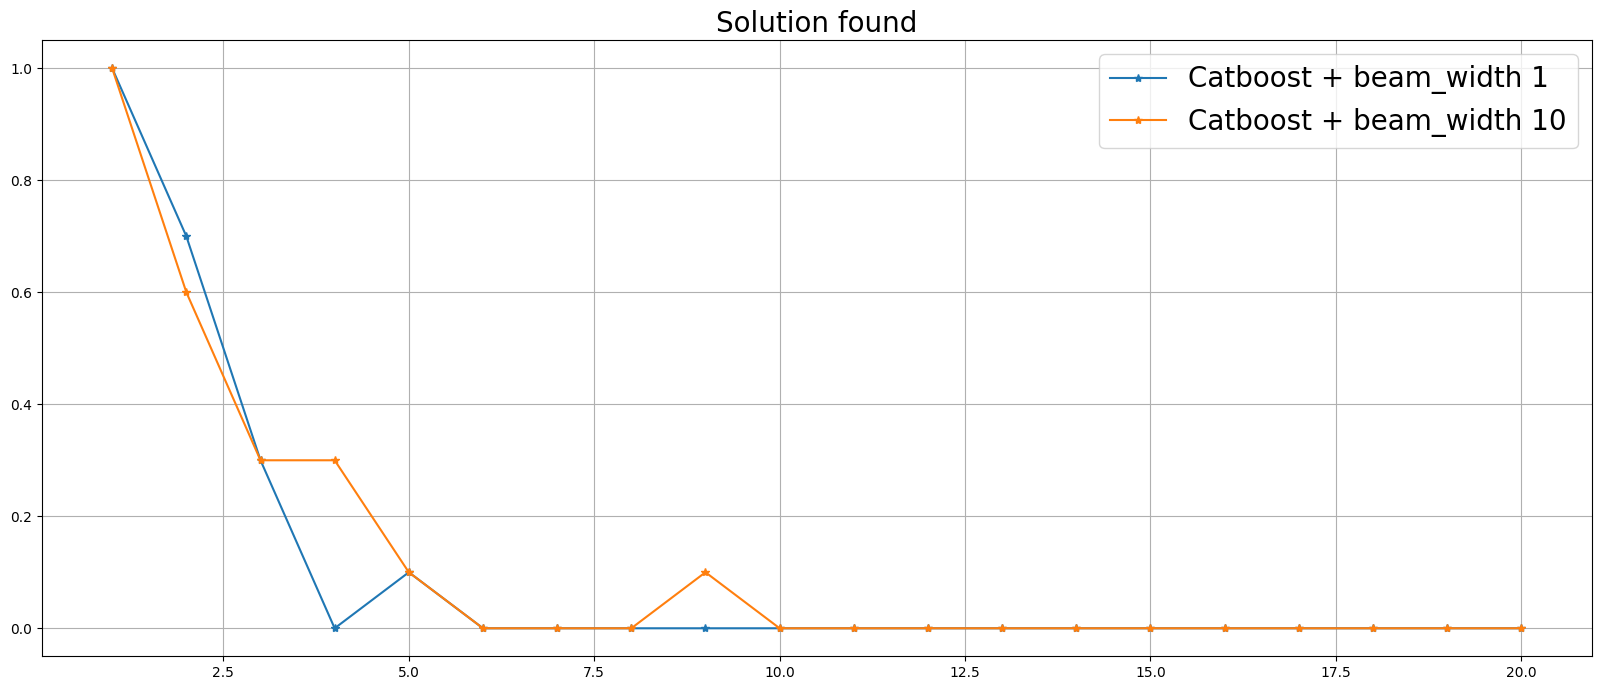

CPU times: user 11min 59s, sys: 518 ms, total: 12min
Wall time: 11min 59s


In [38]:
%%time
# n_scrambles_starting_state = 1000
# print('n_scrambles_starting_state:',n_scrambles_starting_state)

fig = plt.figure(figsize = (20,8))

for beam_width in [1, 10]: 
    
    str_inf = 'Catboost + beam_width ' + str(beam_width)

    df_stat = pd.DataFrame()

    for i_trial in range(10):
        if i_trial < 25:
            #print()
            print('trial:', i_trial)
        # destination state - "solved puzzle state"   
        state_destination = torch.arange( state_size, device=device, dtype = dtype)

        #state_start

        prm_name = 'n_scramble '
        list_prm_value = list(range(1,21))
        for prm_value in list_prm_value:#  5_000,10_000, 30_000]:#, 100_000]:
            n_scrambles_starting_state = prm_value

            # Scramble - generate state which will be start of beam search  
            state_start = state_destination
            for k in range(n_scrambles_starting_state):
                IX_move = np.random.randint(0, n_gens, dtype = int) # random moves indixes
                state_start = state_start[ list_generators[IX_move]] # all_moves[IX_moves,:] ] 

            t0 = time.time()
            flag_found_destination, i_step = beam_search(state_start, model, beam_width =  beam_width, i_step_max = 100, 
                                                         verbose = 0)
            if i_trial < 1:
                print('Found:',flag_found_destination,'steps:', i_step,'beam_width:', beam_width, 
                      'time: %.1f secs'%(time.time()-t0))

            df_stat.loc[i_trial,'Path length.  '+prm_name+str(prm_value)] =  i_step
            df_stat.loc[i_trial,'Solution found. '+prm_name +str(prm_value)] =  int(flag_found_destination)    
            df_stat.loc[i_trial,'Time. '+prm_name+str(prm_value)] =  np.round(time.time()-t0,1)   

    df_stat.to_csv('stat_beam_search_'+prm_name+'_'+str_inf+'.csv')    
    display(df_stat)
    display(df_stat.describe().round(3).T)
    display(df_stat.describe().round(3).to_csv('aggregated_stat_beam_search_'+prm_name+'_'+str_inf+'.csv'))


    df_loc = df_stat.describe()
    dat_loc = []
    col_key = 'Solution found'
    for col in df_stat.columns:
        if not( col_key in col) : continue 
        dat_loc.append(df_loc.loc['mean', col] )

    plt.plot(list_prm_value, dat_loc, '*-',label = str_inf)
    plt.title(col_key , fontsize = 20  )
    plt.legend(fontsize = 20 )
    plt.savefig(col_key.replace('.', ' ') + '.png') 
plt.grid()
plt.show()

In [39]:
print('Done')

Done


In [40]:
# class MatrixDatasetRegr(Dataset):
#     def __init__(self, X, y):
#         self.X = torch.tensor(X, dtype=torch.int64)
#         self.y = torch.tensor(y, dtype=torch.float32)

#     def __len__(self):
#         return len(self.y)

#     def __getitem__(self, idx):
#         x = F.one_hot(self.X[idx], num_classes=self.X.shape[1]).float()
#         return x.unsqueeze(0), self.y[idx]


# train_dataset = MatrixDatasetRegr(X_train, y_train)
# test_dataset = MatrixDatasetRegr(X_test, y_test)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
# class CNN_96x96_SmallKernel(nn.Module):
#     def __init__(self):
#         super(CNN_96x96_SmallKernel, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.bn3 = nn.BatchNorm2d(128)
        
#         self.pool = nn.MaxPool2d(2, 2)
#         self.dropout1 = nn.Dropout2d(0.25)
#         self.dropout2 = nn.Dropout(0.5)
        
#         self.feature_size = 128 * 12 * 12
        
#         self.fc1 = nn.Linear(self.feature_size, 512)
#         self.fc2 = nn.Linear(512, 128)
#         self.fc3 = nn.Linear(128, 1)

#     def forward(self, x):
#         x = self.pool(F.relu(self.bn1(self.conv1(x))))
#         x = self.dropout1(x)
#         x = self.pool(F.relu(self.bn2(self.conv2(x))))
#         x = self.dropout1(x)
#         x = self.pool(F.relu(self.bn3(self.conv3(x))))
#         x = self.dropout1(x)
        
#         x = x.view(-1, self.feature_size)
#         x = F.relu(self.fc1(x))
#         x = self.dropout2(x)
#         x = F.relu(self.fc2(x))
#         x = self.dropout2(x)
#         x = self.fc3(x)
        
#         return x.squeeze(1)
    
# model = CNN_96x96_SmallKernel().to(device)
# criterion = nn.MSELoss()
# optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-5)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)
# pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1000000
# print(f'Total trainable parameters: {pytorch_total_params}')

# # Training loop
# num_epochs = 200
# train_rmse_list, train_r2_list = [], []
# test_rmse_list, test_r2_list = [], []
# loss_list = []


# best_test_rmse = float('inf')
# patience = 20
# no_improve = 0

# for epoch in range(num_epochs):
#     X_train, y_train = prepare_data(list_generators ,n_random_walk_length = 60 ,  n_random_walks_to_generate = 10_000 ) #,    rw_start = None, 
#                  #device=device, dtype = dtype , verbose = 0   )

#     train_dataset = MatrixDatasetRegr(X_train, y_train)
#     train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
#     model.train()
#     for batch_X, batch_y in train_loader:
#         batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
#         optimizer.zero_grad()
#         outputs = model(batch_X)
#         loss = criterion(outputs, batch_y)
#         loss.backward()
#         optimizer.step()
    
#     # Calculate metrics for train and test data
#     train_rmse, train_r2 = calculate_metrics(model, train_loader)
#     test_rmse, test_r2 = calculate_metrics(model, test_loader)
#     train_rmse_list.append(train_rmse)
#     train_r2_list.append(train_r2)
#     test_rmse_list.append(test_rmse)
#     test_r2_list.append(test_r2)
    
#     scheduler.step(test_rmse)
    
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
#     print(f'Train - RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}')
#     print(f'Test  - RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}')
#     # Early stopping
#     if test_rmse < best_test_rmse:
#         best_test_rmse = test_rmse
#         no_improve = 0
#         torch.save(model.state_dict(), 'best_model.pth')
#     else:
#         no_improve += 1
#         if no_improve == patience:
#             print("Early stopping triggered")
#             break
# print('Finished Training')
# print(f'Best metrics: {min(test_rmse_list)=:.4f} {max(test_r2_list)=:.4f}')

# # Plotting the metrics
# plt.figure(figsize=(15, 5))

# plt.subplot(1, 2, 1)
# plt.plot(range(1, len(train_rmse_list)+1), train_rmse_list, label='Train')
# plt.plot(range(1, len(test_rmse_list)+1), test_rmse_list, label='Test')
# plt.title('RMSE')
# plt.xlabel('Epoch')
# plt.ylabel('RMSE')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(range(1, len(train_r2_list)+1), train_r2_list, label='Train')
# plt.plot(range(1, len(test_r2_list)+1), test_r2_list, label='Test')
# plt.title('R²')
# plt.xlabel('Epoch')
# plt.ylabel('R²')
# plt.legend()

# plt.tight_layout()
# plt.show()

In [41]:
# class MatrixDatasetRegr(Dataset):
#     def __init__(self, X, y):
#         self.X = torch.tensor(X, dtype=torch.int64)
#         self.y = torch.tensor(y, dtype=torch.float32)

#     def __len__(self):
#         return len(self.y)

#     def __getitem__(self, idx):
#         x = F.one_hot(self.X[idx], num_classes=self.X.shape[1]).float()
#         return x.unsqueeze(0), self.y[idx]


# train_dataset = MatrixDatasetRegr(X_train, y_train)
# test_dataset = MatrixDatasetRegr(X_test, y_test)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
# class CNN_96x96_Improved(nn.Module):
#     def __init__(self):
#         super(CNN_96x96_Improved, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.bn3 = nn.BatchNorm2d(128)
#         self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
#         self.bn4 = nn.BatchNorm2d(256)
        
#         self.pool = nn.MaxPool2d(2, 2)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.4)
        
#         self.feature_size = 36864
        
#         self.fc1 = nn.Linear(self.feature_size, 1024)
#         self.fc2 = nn.Linear(1024, 256)
#         self.fc3 = nn.Linear(256, 64)
#         self.fc4 = nn.Linear(64, 1)

#     def forward(self, x):
#         x = self.pool(self.relu(self.bn1(self.conv1(x))))
#         x = self.pool(self.relu(self.bn2(self.conv2(x))))
#         x = self.relu(self.bn3(self.conv3(x)))
#         x = self.pool(self.relu(self.bn4(self.conv4(x))))
        
#         x = x.view(64, -1)
# #         print(x.shape)
#         x = self.dropout(self.relu(self.fc1(x)))
#         x = self.dropout(self.relu(self.fc2(x)))
#         x = self.dropout(self.relu(self.fc3(x)))
#         x = self.fc4(x)
        
#         return x.squeeze(1)
    
# model = CNN_96x96_Improved().to(device)
# criterion = nn.MSELoss()
# optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-5)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)
# pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1000000
# print(f'Total trainable parameters: {pytorch_total_params}')

# # Training loop
# num_epochs = 200
# train_rmse_list, train_r2_list = [], []
# test_rmse_list, test_r2_list = [], []
# loss_list = []


# best_test_rmse = float('inf')
# patience = 20
# no_improve = 0

# for epoch in range(num_epochs):
#     X_train, y_train = prepare_data(list_generators ,n_random_walk_length = 60 ,  n_random_walks_to_generate = 10_000 ) #,    rw_start = None, 
#                  #device=device, dtype = dtype , verbose = 0   )

#     train_dataset = MatrixDatasetRegr(X_train, y_train)
#     train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
#     model.train()
#     for batch_X, batch_y in train_loader:
#         batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
#         optimizer.zero_grad()
#         outputs = model(batch_X)
#         loss = criterion(outputs, batch_y)
#         loss.backward()
#         optimizer.step()
    
#     # Calculate metrics for train and test data
#     train_rmse, train_r2 = calculate_metrics(model, train_loader)
#     test_rmse, test_r2 = calculate_metrics(model, test_loader)
#     train_rmse_list.append(train_rmse)
#     train_r2_list.append(train_r2)
#     test_rmse_list.append(test_rmse)
#     test_r2_list.append(test_r2)
    
#     scheduler.step(test_rmse)
    
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
#     print(f'Train - RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}')
#     print(f'Test  - RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}')
#     # Early stopping
#     if test_rmse < best_test_rmse:
#         best_test_rmse = test_rmse
#         no_improve = 0
#         torch.save(model.state_dict(), 'best_model.pth')
#     else:
#         no_improve += 1
#         if no_improve == patience:
#             print("Early stopping triggered")
#             break
# print('Finished Training')
# print(f'Best metrics: {min(test_rmse_list)=:.4f} {max(test_r2_list)=:.4f}')

# # Plotting the metrics
# plt.figure(figsize=(15, 5))

# plt.subplot(1, 2, 1)
# plt.plot(range(1, len(train_rmse_list)+1), train_rmse_list, label='Train')
# plt.plot(range(1, len(test_rmse_list)+1), test_rmse_list, label='Test')
# plt.title('RMSE')
# plt.xlabel('Epoch')
# plt.ylabel('RMSE')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(range(1, len(train_r2_list)+1), train_r2_list, label='Train')
# plt.plot(range(1, len(test_r2_list)+1), test_r2_list, label='Test')
# plt.title('R²')
# plt.xlabel('Epoch')
# plt.ylabel('R²')
# plt.legend()

# plt.tight_layout()
# plt.show()

In [42]:
# class MatrixDatasetRegr(Dataset):
#     def __init__(self, X, y):
#         self.X = torch.tensor(X, dtype=torch.int64)
#         self.y = torch.tensor(y, dtype=torch.float32)

#     def __len__(self):
#         return len(self.y)

#     def __getitem__(self, idx):
#         x = F.one_hot(self.X[idx], num_classes=self.X.shape[1]).float()
#         return x.unsqueeze(0), self.y[idx]


# train_dataset = MatrixDatasetRegr(X_train, y_train)
# test_dataset = MatrixDatasetRegr(X_test, y_test)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
# class CNN_96x96_Improved(nn.Module):
#     def __init__(self):
#         super(CNN_96x96_Improved, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.bn3 = nn.BatchNorm2d(128)
#         self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
#         self.bn4 = nn.BatchNorm2d(256)
        
#         self.pool = nn.MaxPool2d(2, 2)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.4)
        
#         self.feature_size = 36864
        
#         self.fc1 = nn.Linear(self.feature_size, 1024)
#         self.fc2 = nn.Linear(1024, 256)
#         self.fc3 = nn.Linear(256, 64)
#         self.fc4 = nn.Linear(64, 1)

#     def forward(self, x):
#         x = self.pool(self.relu(self.bn1(self.conv1(x))))
#         x = self.pool(self.relu(self.bn2(self.conv2(x))))
#         x = self.relu(self.bn3(self.conv3(x)))
#         x = self.pool(self.relu(self.bn4(self.conv4(x))))
        
#         x = x.view(64, -1)
# #         print(x.shape)
#         x = self.dropout(self.relu(self.fc1(x)))
#         x = self.dropout(self.relu(self.fc2(x)))
#         x = self.dropout(self.relu(self.fc3(x)))
#         x = self.fc4(x)
        
#         return x.squeeze(1)
    
# model = CNN_96x96_Improved().to(device)
# criterion = nn.MSELoss()
# optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-5)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)
# pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1000000
# print(f'Total trainable parameters: {pytorch_total_params}')

# # Training loop
# num_epochs = 200
# train_rmse_list, train_r2_list = [], []
# test_rmse_list, test_r2_list = [], []
# loss_list = []


# best_test_rmse = float('inf')
# patience = 20
# no_improve = 0

# for epoch in range(num_epochs):
#     X_train, y_train = prepare_data(list_generators ,n_random_walk_length = 60 ,  n_random_walks_to_generate = 10_000 ) #,    rw_start = None, 
#                  #device=device, dtype = dtype , verbose = 0   )

#     train_dataset = MatrixDatasetRegr(X_train, y_train)
#     train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
#     model.train()
#     for batch_X, batch_y in train_loader:
#         batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
#         optimizer.zero_grad()
#         outputs = model(batch_X)
#         loss = criterion(outputs, batch_y)
#         loss.backward()
#         optimizer.step()
    
#     # Calculate metrics for train and test data
#     train_rmse, train_r2 = calculate_metrics(model, train_loader)
#     test_rmse, test_r2 = calculate_metrics(model, test_loader)
#     train_rmse_list.append(train_rmse)
#     train_r2_list.append(train_r2)
#     test_rmse_list.append(test_rmse)
#     test_r2_list.append(test_r2)
    
#     scheduler.step(test_rmse)
    
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
#     print(f'Train - RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}')
#     print(f'Test  - RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}')
#     # Early stopping
#     if test_rmse < best_test_rmse:
#         best_test_rmse = test_rmse
#         no_improve = 0
#         torch.save(model.state_dict(), 'best_model.pth')
#     else:
#         no_improve += 1
#         if no_improve == patience:
#             print("Early stopping triggered")
#             break
# print('Finished Training')
# print(f'Best metrics: {min(test_rmse_list)=:.4f} {max(test_r2_list)=:.4f}')

# # Plotting the metrics
# plt.figure(figsize=(15, 5))

# plt.subplot(1, 2, 1)
# plt.plot(range(1, len(train_rmse_list)+1), train_rmse_list, label='Train')
# plt.plot(range(1, len(test_rmse_list)+1), test_rmse_list, label='Test')
# plt.title('RMSE')
# plt.xlabel('Epoch')
# plt.ylabel('RMSE')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(range(1, len(train_r2_list)+1), train_r2_list, label='Train')
# plt.plot(range(1, len(test_r2_list)+1), test_r2_list, label='Test')
# plt.title('R²')
# plt.xlabel('Epoch')
# plt.ylabel('R²')
# plt.legend()

# plt.tight_layout()
# plt.show()